## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [82]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [83]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [84]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [85]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [86]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [87]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('data/titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [88]:
target = 'survived'

In [89]:
vars_num = list(data.select_dtypes(include = np.number).columns)# fill your code here
vars_num.remove(target)
vars_num.remove('pclass')

vars_cat = list(data.select_dtypes(exclude = np.number).columns)# fill your code here
vars_cat.append('pclass')

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 4
Number of categorical variables: 5


### Find missing values in variables

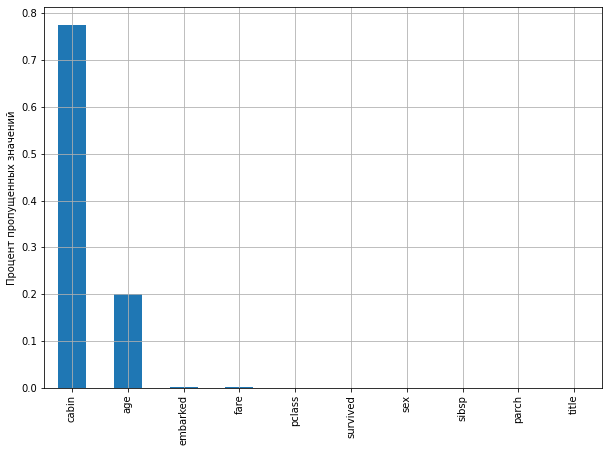

In [90]:
data.isna().mean().sort_values(ascending = False).plot.bar(figsize = (10,7), grid = True)
plt.ylabel('Процент пропущенных значений')

plt.show()

In [91]:
# first in numerical variables
vars_with_na_num = [col for col in vars_num if data[col].isnull().sum() >0]
print(f'Из {len(vars_num)} числовых, числовые с пропущенными {len(vars_with_na_num)}')

Из 4 числовых, числовые с пропущенными 2


In [92]:
# now in categorical variables
vars_with_na_cat = [col for col in vars_cat if data[col].isnull().sum() >0]
print(f'Из {len(vars_cat)} категориальных, категориальные с пропущенными {len(vars_with_na_cat)}')

Из 5 категориальных, категориальные с пропущенными 2


In [93]:
def na_var_and_target(df, var):
    
    test = df.copy()
    test[var] = np.where(test[var].isnull(),1,0)
    test.groupby(var)[target].agg(['mean','std']).plot(kind = 'barh', y = 'mean',xerr ='std')
    plt.show()

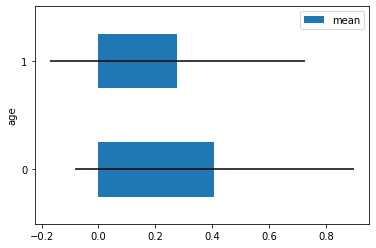

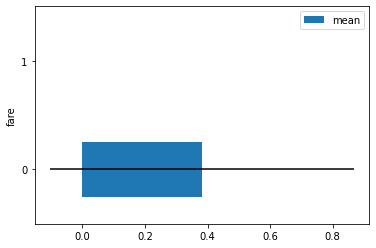

In [94]:
for var in vars_with_na_num:
    na_var_and_target(data, var)

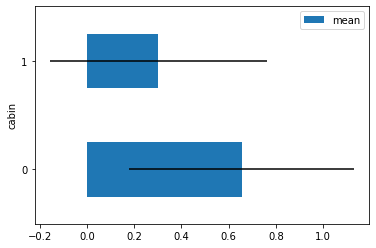

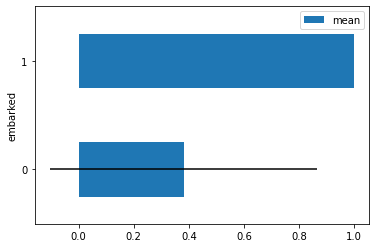

In [95]:
for var in vars_with_na_cat:
    na_var_and_target(data, var)

### Determine cardinality of categorical variables

<AxesSubplot:>

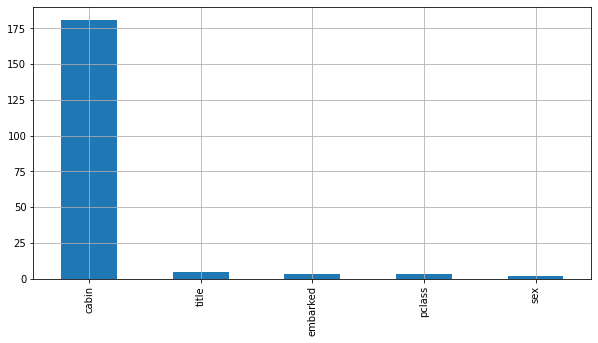

In [96]:
data[vars_cat].nunique().sort_values(ascending = False).plot.bar(figsize = (10,5), grid = True)

#
пока уберем номер кабины, но можно использовать первую букву

### Determine the distribution of numerical variables

In [97]:
descrite_vars = [col for col in vars_num if data[col].nunique() < 20]
data[descrite_vars].head(2)

,sibsp,parch
0,0,0
1,1,2


<AxesSubplot:ylabel='embarked'>

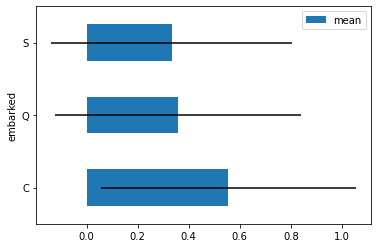

In [98]:
data.groupby(var)[target].agg(['mean','std']).plot(kind = 'barh', y = 'mean',xerr ='std')

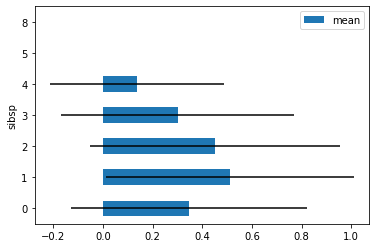

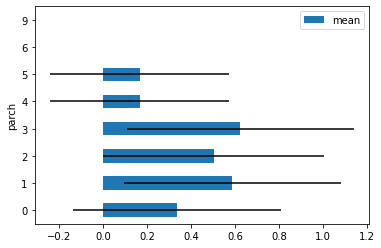

In [99]:
import seaborn as sns
for var in descrite_vars:
    data.groupby(var)[target].agg(['mean','std']).plot(kind = 'barh', y = 'mean',xerr ='std')
    plt.show()

In [100]:
cont_vars = [col for col in vars_num if col not in descrite_vars]
cont_vars

['age', 'fare']

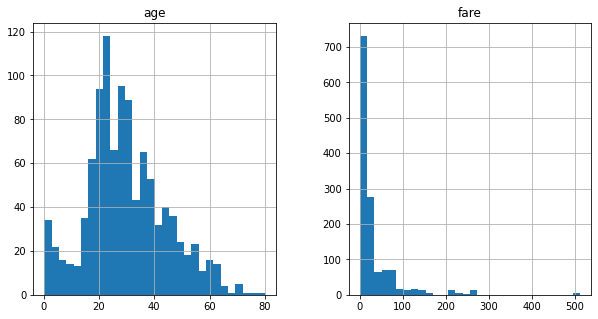

In [101]:
data[cont_vars].hist(bins = 30, figsize = (10,5))
plt.show()

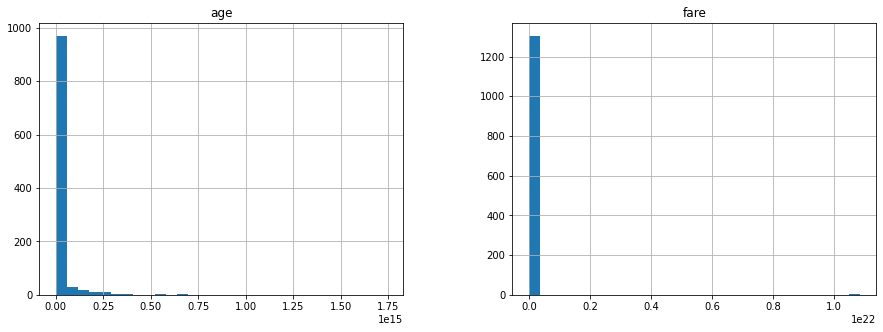

In [54]:
from scipy import stats

yeo_transform = data.copy()

for var in cont_vars:
    
    yeo_transform[var], param = stats.yeojohnson (yeo_transform[var])
    
yeo_transform[cont_vars].hist(bins=30, figsize = (15,5))
plt.show()

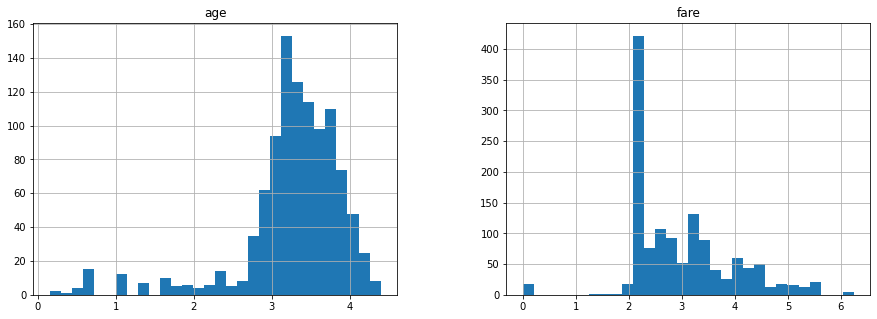

In [66]:
log_transform = data.copy()

for var in cont_vars:
    
    log_transform[var] = np.log(log_transform[var]+1)
    
log_transform[cont_vars].hist(bins=30, figsize = (15,5))
plt.show()

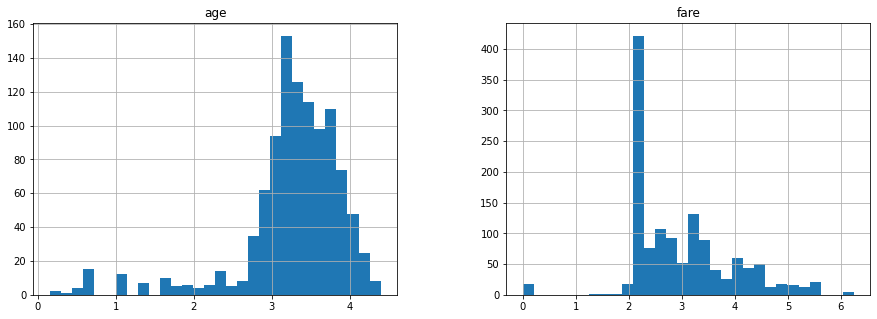

In [216]:
for var in cont_vars:
    
    data[var] = np.log(data[var]+1)
    
data[cont_vars].hist(bins=30, figsize = (15,5))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [217]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 10), (262, 10))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [218]:
data['cabin'] = data['cabin'].apply(lambda x: x[0] if type(x) == str  else x)

In [219]:
X_train['cabin'] = X_train['cabin'].apply(lambda x: x[0] if type(x) == str  else x)
X_test['cabin'] = X_test['cabin'].apply(lambda x: x[0] if type(x) == str  else x)
#na_var_and_target(X_train, 'cabin_letter')

<AxesSubplot:ylabel='cabin'>

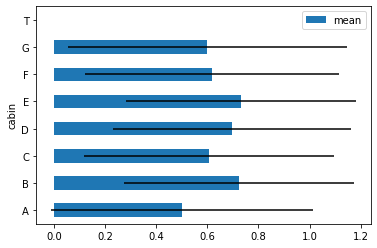

In [220]:
data.groupby('cabin')[target].agg(['mean','std']).plot(kind = 'barh', y = 'mean',xerr ='std')

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [221]:
for col in vars_num:
    X_train[col+'_na'] = np.where(X_train[col].isnull(),1,0)
    X_test[col+'_na'] = np.where(X_test[col].isnull(),1,0)

In [222]:
for col in vars_num:
    median = X_train[col].median()
    X_train[col] = X_train[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)
    

In [223]:
X_train[vars_num].isna().mean()

age      0.0
sibsp    0.0
parch    0.0
fare     0.0
dtype: float64

### Replace Missing data in categorical variables with the string **Missing**

In [224]:
X_train[vars_with_na_cat] = X_train[vars_with_na_cat].fillna('Missing')
X_test[vars_with_na_cat] = X_test[vars_with_na_cat].fillna('Missing')

In [225]:
X_train[vars_with_na_cat].isna().mean()

cabin       0.0
embarked    0.0
dtype: float64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [226]:
def find_rare_labels(data, var, border):
    df = data.copy()
    
    group = df.groupby(var)[var].count() / len(df)
    
    return group[group < border].index

In [227]:
for col in vars_cat:
    rare_labels = find_rare_labels(X_train, col, 0.05)
    
    X_train[col] = np.where(X_train[col].isin(rare_labels),'Rare', X_train[col])
    X_test[col] = np.where(X_test[col].isin(rare_labels),'Rare', X_test[col])

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [228]:
X_train[vars_cat]

,sex,cabin,embarked,title,pclass
1118,male,Missing,S,Mr,3
44,female,Rare,C,Miss,1
1072,male,Missing,Q,Mr,3
1130,female,Missing,S,Miss,3
574,male,Missing,S,Mr,2
...,...,...,...,...,...
763,female,Missing,S,Miss,3
835,male,Missing,S,Mr,3
1216,female,Missing,Q,Miss,3
559,female,Missing,S,Miss,2


In [229]:
def one_hot_feature(X_train, X_test, col_name):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    un_vals = X_train[col_name].unique()
    new_cat_col_names = []
    for val in un_vals:
        X_train[col_name + '_' + val  ] = np.where(X_train[col_name] == val,1,0)
        X_test[col_name + '_' + val  ] = np.where(X_test[col_name] == val,1,0)
        new_cat_col_names.append(col_name + '_' + val)
    
    X_train = X_train.drop(col_name, axis = 1)
    X_test = X_test.drop(col_name, axis = 1)

    return X_train, X_test, new_cat_col_names
     

In [230]:
vars_cat_new = list(vars_cat)


for col_name in vars_cat:    
    print(col_name)
    X_train, X_test, new_cat_names = one_hot_feature(X_train, X_test, col_name)
    vars_cat_new.remove(col_name)
    vars_cat_new = vars_cat_new + new_cat_names

sex
cabin
embarked
title
pclass


In [231]:
X_train

,age,sibsp,parch,fare,cabin_letter,age_na,sibsp_na,parch_na,fare_na,sex_male,sex_female,cabin_Missing,cabin_Rare,cabin_C,embarked_S,embarked_C,embarked_Q,embarked_Rare,title_Mr,title_Miss,title_Mrs,title_Rare,pclass_3,pclass_1,pclass_2
1118,3.258097,0,0,2.188856,NaN,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
44,3.737670,0,0,4.908972,E,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
1072,3.367296,0,0,2.167143,NaN,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
1130,2.944439,0,0,2.171907,NaN,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
574,3.401197,1,0,3.091042,NaN,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.154179,1,2,3.071535,NaN,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
835,3.367296,0,0,2.202765,NaN,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
1216,3.367296,0,0,2.167143,NaN,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0
559,3.044522,0,0,3.630985,NaN,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1


In [232]:
vars_cat_new

['sex_male',
 'sex_female',
 'cabin_Missing',
 'cabin_Rare',
 'cabin_C',
 'embarked_S',
 'embarked_C',
 'embarked_Q',
 'embarked_Rare',
 'title_Mr',
 'title_Miss',
 'title_Mrs',
 'title_Rare',
 'pclass_3',
 'pclass_1',
 'pclass_2']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [233]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[vars_num + vars_cat_new], y_train)

StandardScaler()

In [234]:
X_train_transformed = scaler.transform(X_train[vars_num + vars_cat_new])
X_test_transformed = scaler.transform(X_test[vars_num + vars_cat_new])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [235]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 0.0005, random_state=0)
model.fit(X_train_transformed, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [236]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
preds = model.predict(X_test_transformed)
probs = model.predict_proba(X_test_transformed)[:,1]
ac_score = accuracy_score(y_test, preds)
roc_auc = roc_auc_score(y_test, probs)
print('Accuracy', ac_score)
print('ROC-AUC', roc_auc)
print(classification_report(y_test, preds))

Accuracy 0.732824427480916
ROC-AUC 0.8487345679012346
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       162
           1       1.00      0.30      0.46       100

    accuracy                           0.73       262
   macro avg       0.85      0.65      0.64       262
weighted avg       0.81      0.73      0.68       262



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**